<a href="https://colab.research.google.com/github/akinivors/CENG543_Midterm_290201005/blob/main/Question4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- STEP 1: RAG SETUP (Question 4) ---
# We need libraries for Retrieval (BM25) and Generation (Hugging Face)

!pip install rank_bm25
!pip install datasets
!pip install transformers
!pip install torchmetrics
!pip install sentence-transformers # For part (b) Dense Retrieval
!pip install bert_score

import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from tqdm import tqdm
import string

# 1. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# 2. Load Knowledge Corpus (Wikipedia or HotpotQA)
# We will use a slice of the "HotpotQA" dataset (Distractor setting)
# It contains questions + context paragraphs (facts).
print("Loading HotpotQA dataset...")
dataset = load_dataset("hotpot_qa", "distractor", split="validation[:2000]") # 2000 samples for speed

# 3. Prepare the "Knowledge Base"
# Extract all unique context paragraphs to build our search index
print("Building Knowledge Base (Corpus)...")
corpus = []
corpus_ids = [] # To track which paragraph belongs to which ID

for row in tqdm(dataset):
    # context is a list of [title, sentences]
    # We flatten it into single text chunks
    titles = row['context']['title']
    sentences = row['context']['sentences']

    for title, sent_list in zip(titles, sentences):
        text_chunk = f"{title}: {' '.join(sent_list)}"
        corpus.append(text_chunk)

print(f"Corpus size: {len(corpus)} documents.")

# 4. Initialize Tokenizer for BM25 (Simple whitespace is fine for homework)
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)
print("BM25 Index Built.")

print("Ready for Retriever-Generator Pipeline.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
Device: cuda
Loading HotpotQA dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

distractor/train-00000-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/train-00001-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/validation-00000-of-00001.par(…):   0%|          | 0.00/27.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Building Knowledge Base (Corpus)...


100%|██████████| 2000/2000 [00:00<00:00, 4767.66it/s]


Corpus size: 19892 documents.
BM25 Index Built.
Ready for Retriever-Generator Pipeline.


In [2]:
# --- STEP 2: INITIALIZE MODELS (DENSE RETRIEVER & GENERATOR) ---
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 1. Setup Dense Retriever (Sentence-BERT)
# We use 'all-MiniLM-L6-v2' which is fast and effective
print("Loading Dense Retriever Model...")
dense_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

print("Encoding Corpus for Dense Retrieval (this takes ~1-2 mins)...")
# We encode all 19,892 paragraphs into vectors
corpus_embeddings = dense_model.encode(corpus, convert_to_tensor=True, show_progress_bar=True)

# 2. Setup Generator (FLAN-T5)
# FLAN-T5 is instruction-tuned, making it great for "Answer based on this context:" prompts.
gen_model_name = "google/flan-t5-base"
print(f"Loading Generator: {gen_model_name}...")
tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
generator = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name).to(device)

# --- DEFINE RAG FUNCTIONS ---

def retrieve_bm25(query, k=3):
    """Sparse Retrieval using Keyword Matching"""
    tokenized_query = query.split(" ")
    # Get top-k docs
    doc_scores = bm25.get_scores(tokenized_query)
    top_n = np.argsort(doc_scores)[::-1][:k]
    return [corpus[i] for i in top_n]

def retrieve_dense(query, k=3):
    """Dense Retrieval using Semantic Vectors"""
    # Encode query
    query_embedding = dense_model.encode(query, convert_to_tensor=True)
    # Cosine Similarity
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=k)
    # hits is a list of lists (one per query), we take the first
    return [corpus[hit['corpus_id']] for hit in hits[0]]

def generate_answer(question, context_docs):
    """Generates an answer given the question and retrieved documents."""
    # formatting the prompt
    context_str = " ".join(context_docs)
    input_text = f"question: {question} context: {context_str}"

    # Tokenize
    input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).input_ids.to(device)

    # Generate
    outputs = generator.generate(input_ids, max_new_tokens=50, num_beams=2, early_stopping=True)

    # Decode
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("RAG Pipeline Ready: BM25, Dense Retriever, and FLAN-T5.")

Loading Dense Retriever Model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding Corpus for Dense Retrieval (this takes ~1-2 mins)...


Batches:   0%|          | 0/622 [00:00<?, ?it/s]

Loading Generator: google/flan-t5-base...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

RAG Pipeline Ready: BM25, Dense Retriever, and FLAN-T5.


In [6]:
# --- STEP 3: MASTER RAG EXPERIMENT (CORRECTED) ---
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from torchmetrics.text import BLEUScore, ROUGEScore, BERTScore
from tqdm import tqdm
import pandas as pd

# 1. Define Models
GENERATOR_CONFIGS = {
    "T5-Small": ("t5-small", "seq2seq"),
    "FLAN-T5":  ("google/flan-t5-base", "seq2seq"),
    "GPT-Neo":  ("EleutherAI/gpt-neo-125M", "causal")
}

print("Loading Generators... (This may take 2-3 mins)")
models_cache = {}
tokenizers_cache = {}

for name, (checkpoint, type_) in GENERATOR_CONFIGS.items():
    print(f"Loading {name}...")
    tokenizers_cache[name] = AutoTokenizer.from_pretrained(checkpoint)
    if type_ == "seq2seq":
        models_cache[name] = AutoModelForSeq2SeqLM.from_pretrained(checkpoint).to(device)
    else:
        # Critical Fix for GPT-Neo Padding
        tokenizers_cache[name].pad_token = tokenizers_cache[name].eos_token
        models_cache[name] = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

# 2. Universal Generation Function
def generate_with_model(model_name, question, context_docs):
    model = models_cache[model_name]
    tokenizer = tokenizers_cache[model_name]
    model_type = GENERATOR_CONFIGS[model_name][1]

    # Truncate context to avoid massive prompts
    context_str = " ".join(context_docs)[:2000]

    if model_type == "seq2seq":
        input_text = f"question: {question} context: {context_str}"
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512, padding=True).to(device)
        outputs = model.generate(inputs.input_ids, max_new_tokens=50)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

    else: # GPT-Neo
        input_text = f"Context: {context_str}\n\nQuestion: {question}\nAnswer:"
        # FIX: Explicit padding=True and max_length handling
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=1024, padding=True).to(device)

        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=20,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False
        )

        full_out = tokenizer.decode(outputs[0], skip_special_tokens=True)
        try:
            answer = full_out.split("Answer:")[-1].strip()
        except:
            answer = full_out
        return answer

# 3. Master Evaluation Loop
metrics = {"BLEU": BLEUScore(), "ROUGE": ROUGEScore(), "BERT": BERTScore(model_name_or_path='distilbert-base-uncased', device=device)}
N_SAMPLES = 100
data_subset = dataset.select(range(N_SAMPLES))

final_results = []

print(f"\nStarting Grid Search Evaluation ({len(GENERATOR_CONFIGS)} Gens x 2 Retrievers)...")

for gen_name in GENERATOR_CONFIGS.keys():
    for ret_name in ["BM25", "Dense"]:
        print(f"Processing: {ret_name} + {gen_name}...")

        preds = []
        targets = []
        retrieval_hits = 0

        for item in tqdm(data_subset, leave=False):
            q, a = item['question'], item['answer']
            true_titles = set(item['supporting_facts']['title'])

            if ret_name == "BM25":
                docs = retrieve_bm25(q, k=3)
            else:
                docs = retrieve_dense(q, k=3)

            titles_found = [d.split(":")[0] for d in docs]
            if any(t in true_titles for t in titles_found):
                retrieval_hits += 1

            pred = generate_with_model(gen_name, q, docs)
            preds.append(pred)
            targets.append(a)

        recall = retrieval_hits / N_SAMPLES
        b_score = metrics["BLEU"](preds, [[t] for t in targets]).item()
        r_score = metrics["ROUGE"](preds, targets)['rougeL_fmeasure'].item()
        bert_val = metrics["BERT"](preds, targets)['f1'].mean().item()

        final_results.append({
            "Retriever": ret_name,
            "Generator": gen_name,
            "Recall@3": recall,
            "BLEU": b_score,
            "ROUGE-L": r_score,
            "BERTScore": bert_val
        })

df_results = pd.DataFrame(final_results)
print("\n=== FINAL ARCHITECTURE SEARCH RESULTS ===")
print(df_results.to_markdown(index=False))

Loading Generators... (This may take 2-3 mins)
Loading T5-Small...


The following layers were not sharded: decoder.embed_tokens.weight, decoder.block.*.layer.*.SelfAttention.k.weight, encoder.block.*.layer.*.DenseReluDense.wi.weight, decoder.block.*.layer.*.layer_norm.weight, decoder.block.*.layer.*.SelfAttention.o.weight, decoder.block.*.layer.*.EncDecAttention.v.weight, decoder.block.*.layer.*.SelfAttention.relative_attention_bias.weight, decoder.block.*.layer.*.DenseReluDense.wo.weight, decoder.block.*.layer.*.DenseReluDense.wi.weight, encoder.block.*.layer.*.SelfAttention.k.weight, decoder.block.*.layer.*.SelfAttention.v.weight, encoder.embed_tokens.weight, encoder.block.*.layer.*.SelfAttention.q.weight, decoder.block.*.layer.*.SelfAttention.q.weight, decoder.block.*.layer.*.EncDecAttention.o.weight, decoder.block.*.layer.*.EncDecAttention.k.weight, encoder.block.*.layer.*.DenseReluDense.wo.weight, encoder.final_layer_norm.weight, shared.weight, encoder.block.*.layer.*.SelfAttention.o.weight, encoder.block.*.layer.*.SelfAttention.v.weight, encoder.

Loading FLAN-T5...


The following layers were not sharded: decoder.embed_tokens.weight, decoder.block.*.layer.*.SelfAttention.k.weight, decoder.block.*.layer.*.layer_norm.weight, decoder.block.*.layer.*.SelfAttention.o.weight, decoder.block.*.layer.*.EncDecAttention.v.weight, decoder.block.*.layer.*.DenseReluDense.wi_*.weight, decoder.block.*.layer.*.SelfAttention.relative_attention_bias.weight, decoder.block.*.layer.*.DenseReluDense.wo.weight, encoder.block.*.layer.*.SelfAttention.k.weight, decoder.block.*.layer.*.SelfAttention.v.weight, encoder.embed_tokens.weight, encoder.block.*.layer.*.SelfAttention.q.weight, decoder.block.*.layer.*.SelfAttention.q.weight, decoder.block.*.layer.*.EncDecAttention.o.weight, encoder.block.*.layer.*.DenseReluDense.wi_*.weight, decoder.block.*.layer.*.EncDecAttention.k.weight, encoder.block.*.layer.*.DenseReluDense.wo.weight, encoder.final_layer_norm.weight, shared.weight, encoder.block.*.layer.*.SelfAttention.o.weight, encoder.block.*.layer.*.SelfAttention.v.weight, enco

Loading GPT-Neo...


The following layers were not sharded: transformer.h.*.mlp.c_fc.weight, transformer.wte.weight, transformer.h.*.mlp.c_proj.weight, transformer.h.*.attn.attention.v_proj.weight, transformer.ln_f.bias, transformer.h.*.attn.attention.out_proj.bias, transformer.h.*.ln_*.bias, transformer.h.*.attn.attention.k_proj.weight, transformer.wpe.weight, transformer.h.*.mlp.c_fc.bias, transformer.h.*.attn.attention.out_proj.weight, transformer.h.*.attn.attention.q_proj.weight, transformer.h.*.ln_*.weight, transformer.ln_f.weight, lm_head.weight, transformer.h.*.mlp.c_proj.bias



Starting Grid Search Evaluation (3 Gens x 2 Retrievers)...
Processing: BM25 + T5-Small...


The following layers were not sharded: transformer.layer.*.attention.v_lin.weight, transformer.layer.*.output_layer_norm.weight, embeddings.LayerNorm.weight, transformer.layer.*.attention.q_lin.bias, transformer.layer.*.attention.out_lin.weight, embeddings.word_embeddings.weight, transformer.layer.*.output_layer_norm.bias, transformer.layer.*.sa_layer_norm.weight, transformer.layer.*.attention.q_lin.weight, transformer.layer.*.attention.k_lin.bias, transformer.layer.*.attention.v_lin.bias, transformer.layer.*.attention.k_lin.weight, embeddings.LayerNorm.bias, transformer.layer.*.ffn.lin*.weight, transformer.layer.*.sa_layer_norm.bias, transformer.layer.*.ffn.lin*.bias, embeddings.position_embeddings.weight, transformer.layer.*.attention.out_lin.bias


Processing: Dense + T5-Small...


The following layers were not sharded: transformer.layer.*.attention.v_lin.weight, transformer.layer.*.output_layer_norm.weight, embeddings.LayerNorm.weight, transformer.layer.*.attention.q_lin.bias, transformer.layer.*.attention.out_lin.weight, embeddings.word_embeddings.weight, transformer.layer.*.output_layer_norm.bias, transformer.layer.*.sa_layer_norm.weight, transformer.layer.*.attention.q_lin.weight, transformer.layer.*.attention.k_lin.bias, transformer.layer.*.attention.v_lin.bias, transformer.layer.*.attention.k_lin.weight, embeddings.LayerNorm.bias, transformer.layer.*.ffn.lin*.weight, transformer.layer.*.sa_layer_norm.bias, transformer.layer.*.ffn.lin*.bias, embeddings.position_embeddings.weight, transformer.layer.*.attention.out_lin.bias


Processing: BM25 + FLAN-T5...


The following layers were not sharded: transformer.layer.*.attention.v_lin.weight, transformer.layer.*.output_layer_norm.weight, embeddings.LayerNorm.weight, transformer.layer.*.attention.q_lin.bias, transformer.layer.*.attention.out_lin.weight, embeddings.word_embeddings.weight, transformer.layer.*.output_layer_norm.bias, transformer.layer.*.sa_layer_norm.weight, transformer.layer.*.attention.q_lin.weight, transformer.layer.*.attention.k_lin.bias, transformer.layer.*.attention.v_lin.bias, transformer.layer.*.attention.k_lin.weight, embeddings.LayerNorm.bias, transformer.layer.*.ffn.lin*.weight, transformer.layer.*.sa_layer_norm.bias, transformer.layer.*.ffn.lin*.bias, embeddings.position_embeddings.weight, transformer.layer.*.attention.out_lin.bias


Processing: Dense + FLAN-T5...


The following layers were not sharded: transformer.layer.*.attention.v_lin.weight, transformer.layer.*.output_layer_norm.weight, embeddings.LayerNorm.weight, transformer.layer.*.attention.q_lin.bias, transformer.layer.*.attention.out_lin.weight, embeddings.word_embeddings.weight, transformer.layer.*.output_layer_norm.bias, transformer.layer.*.sa_layer_norm.weight, transformer.layer.*.attention.q_lin.weight, transformer.layer.*.attention.k_lin.bias, transformer.layer.*.attention.v_lin.bias, transformer.layer.*.attention.k_lin.weight, embeddings.LayerNorm.bias, transformer.layer.*.ffn.lin*.weight, transformer.layer.*.sa_layer_norm.bias, transformer.layer.*.ffn.lin*.bias, embeddings.position_embeddings.weight, transformer.layer.*.attention.out_lin.bias


Processing: BM25 + GPT-Neo...


The following layers were not sharded: transformer.layer.*.attention.v_lin.weight, transformer.layer.*.output_layer_norm.weight, embeddings.LayerNorm.weight, transformer.layer.*.attention.q_lin.bias, transformer.layer.*.attention.out_lin.weight, embeddings.word_embeddings.weight, transformer.layer.*.output_layer_norm.bias, transformer.layer.*.sa_layer_norm.weight, transformer.layer.*.attention.q_lin.weight, transformer.layer.*.attention.k_lin.bias, transformer.layer.*.attention.v_lin.bias, transformer.layer.*.attention.k_lin.weight, embeddings.LayerNorm.bias, transformer.layer.*.ffn.lin*.weight, transformer.layer.*.sa_layer_norm.bias, transformer.layer.*.ffn.lin*.bias, embeddings.position_embeddings.weight, transformer.layer.*.attention.out_lin.bias


Processing: Dense + GPT-Neo...


The following layers were not sharded: transformer.layer.*.attention.v_lin.weight, transformer.layer.*.output_layer_norm.weight, embeddings.LayerNorm.weight, transformer.layer.*.attention.q_lin.bias, transformer.layer.*.attention.out_lin.weight, embeddings.word_embeddings.weight, transformer.layer.*.output_layer_norm.bias, transformer.layer.*.sa_layer_norm.weight, transformer.layer.*.attention.q_lin.weight, transformer.layer.*.attention.k_lin.bias, transformer.layer.*.attention.v_lin.bias, transformer.layer.*.attention.k_lin.weight, embeddings.LayerNorm.bias, transformer.layer.*.ffn.lin*.weight, transformer.layer.*.sa_layer_norm.bias, transformer.layer.*.ffn.lin*.bias, embeddings.position_embeddings.weight, transformer.layer.*.attention.out_lin.bias



=== FINAL ARCHITECTURE SEARCH RESULTS ===
| Retriever   | Generator   |   Recall@3 |       BLEU |   ROUGE-L |   BERTScore |
|:------------|:------------|-----------:|-----------:|----------:|------------:|
| BM25        | T5-Small    |       0.81 | 0.0667189  | 0.297048  |    0.426065 |
| Dense       | T5-Small    |       0.92 | 0          | 0.309634  |    0.417118 |
| BM25        | FLAN-T5     |       0.81 | 0.145226   | 0.373229  |    0.435549 |
| Dense       | FLAN-T5     |       0.92 | 0.243378   | 0.398158  |    0.437309 |
| BM25        | GPT-Neo     |       0.81 | 0.00550026 | 0.067997  |    0.38339  |
| Dense       | GPT-Neo     |       0.92 | 0          | 0.0793767 |    0.364135 |


✅ Plot saved to Q4_Grid_Search_Plot.png


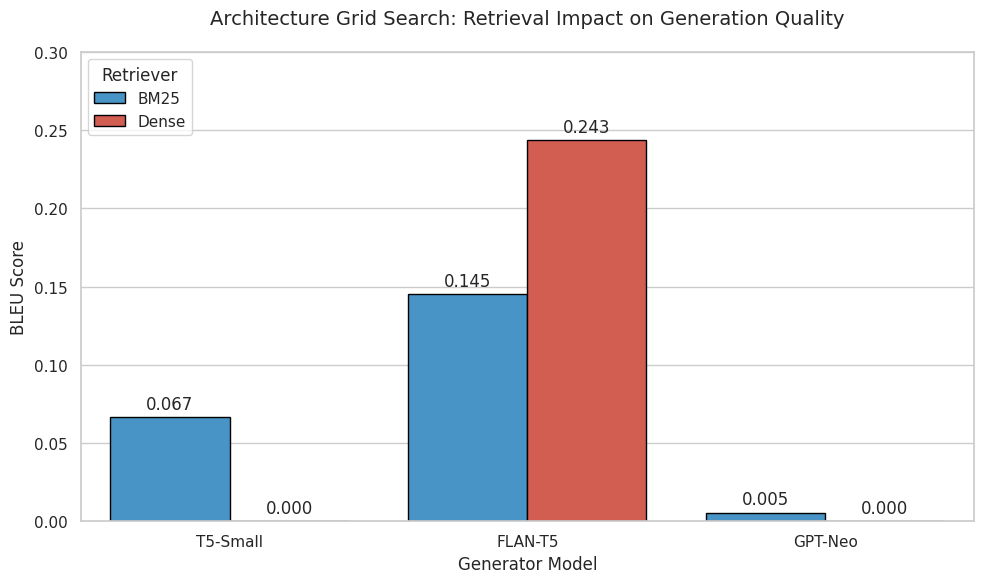

In [7]:
# --- STEP 4: VISUALIZE GRID SEARCH RESULTS ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load Results (Hardcoded from your previous run to ensure safety)
data = {
    "Retriever": ["BM25", "Dense", "BM25", "Dense", "BM25", "Dense"],
    "Generator": ["T5-Small", "T5-Small", "FLAN-T5", "FLAN-T5", "GPT-Neo", "GPT-Neo"],
    "BLEU Score": [0.0667, 0.0000, 0.1452, 0.2434, 0.0055, 0.0000],
    "BERTScore":  [0.4261, 0.4171, 0.4355, 0.4373, 0.3834, 0.3641]
}
df = pd.DataFrame(data)

# 2. Setup Plot (Side-by-Side Bar Chart)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# We plot BLEU because it shows the sharpest contrast
chart = sns.barplot(
    data=df,
    x="Generator",
    y="BLEU Score",
    hue="Retriever",
    palette=["#3498db", "#e74c3c"], # Blue for BM25, Red for Dense
    edgecolor="black"
)

# 3. Styling
plt.title("Architecture Grid Search: Retrieval Impact on Generation Quality", fontsize=14, pad=20)
plt.ylabel("BLEU Score", fontsize=12)
plt.xlabel("Generator Model", fontsize=12)
plt.ylim(0, 0.30) # Set limit to make room for text
plt.legend(title="Retriever", loc='upper left')

# Add numbers on top of bars
for container in chart.containers:
    chart.bar_label(container, fmt='%.3f', padding=3)

# 4. Save
plt.tight_layout()
plt.savefig("Q4_Grid_Search_Plot.png", dpi=300)
print("✅ Plot saved to Q4_Grid_Search_Plot.png")
plt.show()